In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import re
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
train = pd.read_json('data/cook_train.json')
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
train.iloc[0].ingredients

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

Text(0, 0.5, 'Count')

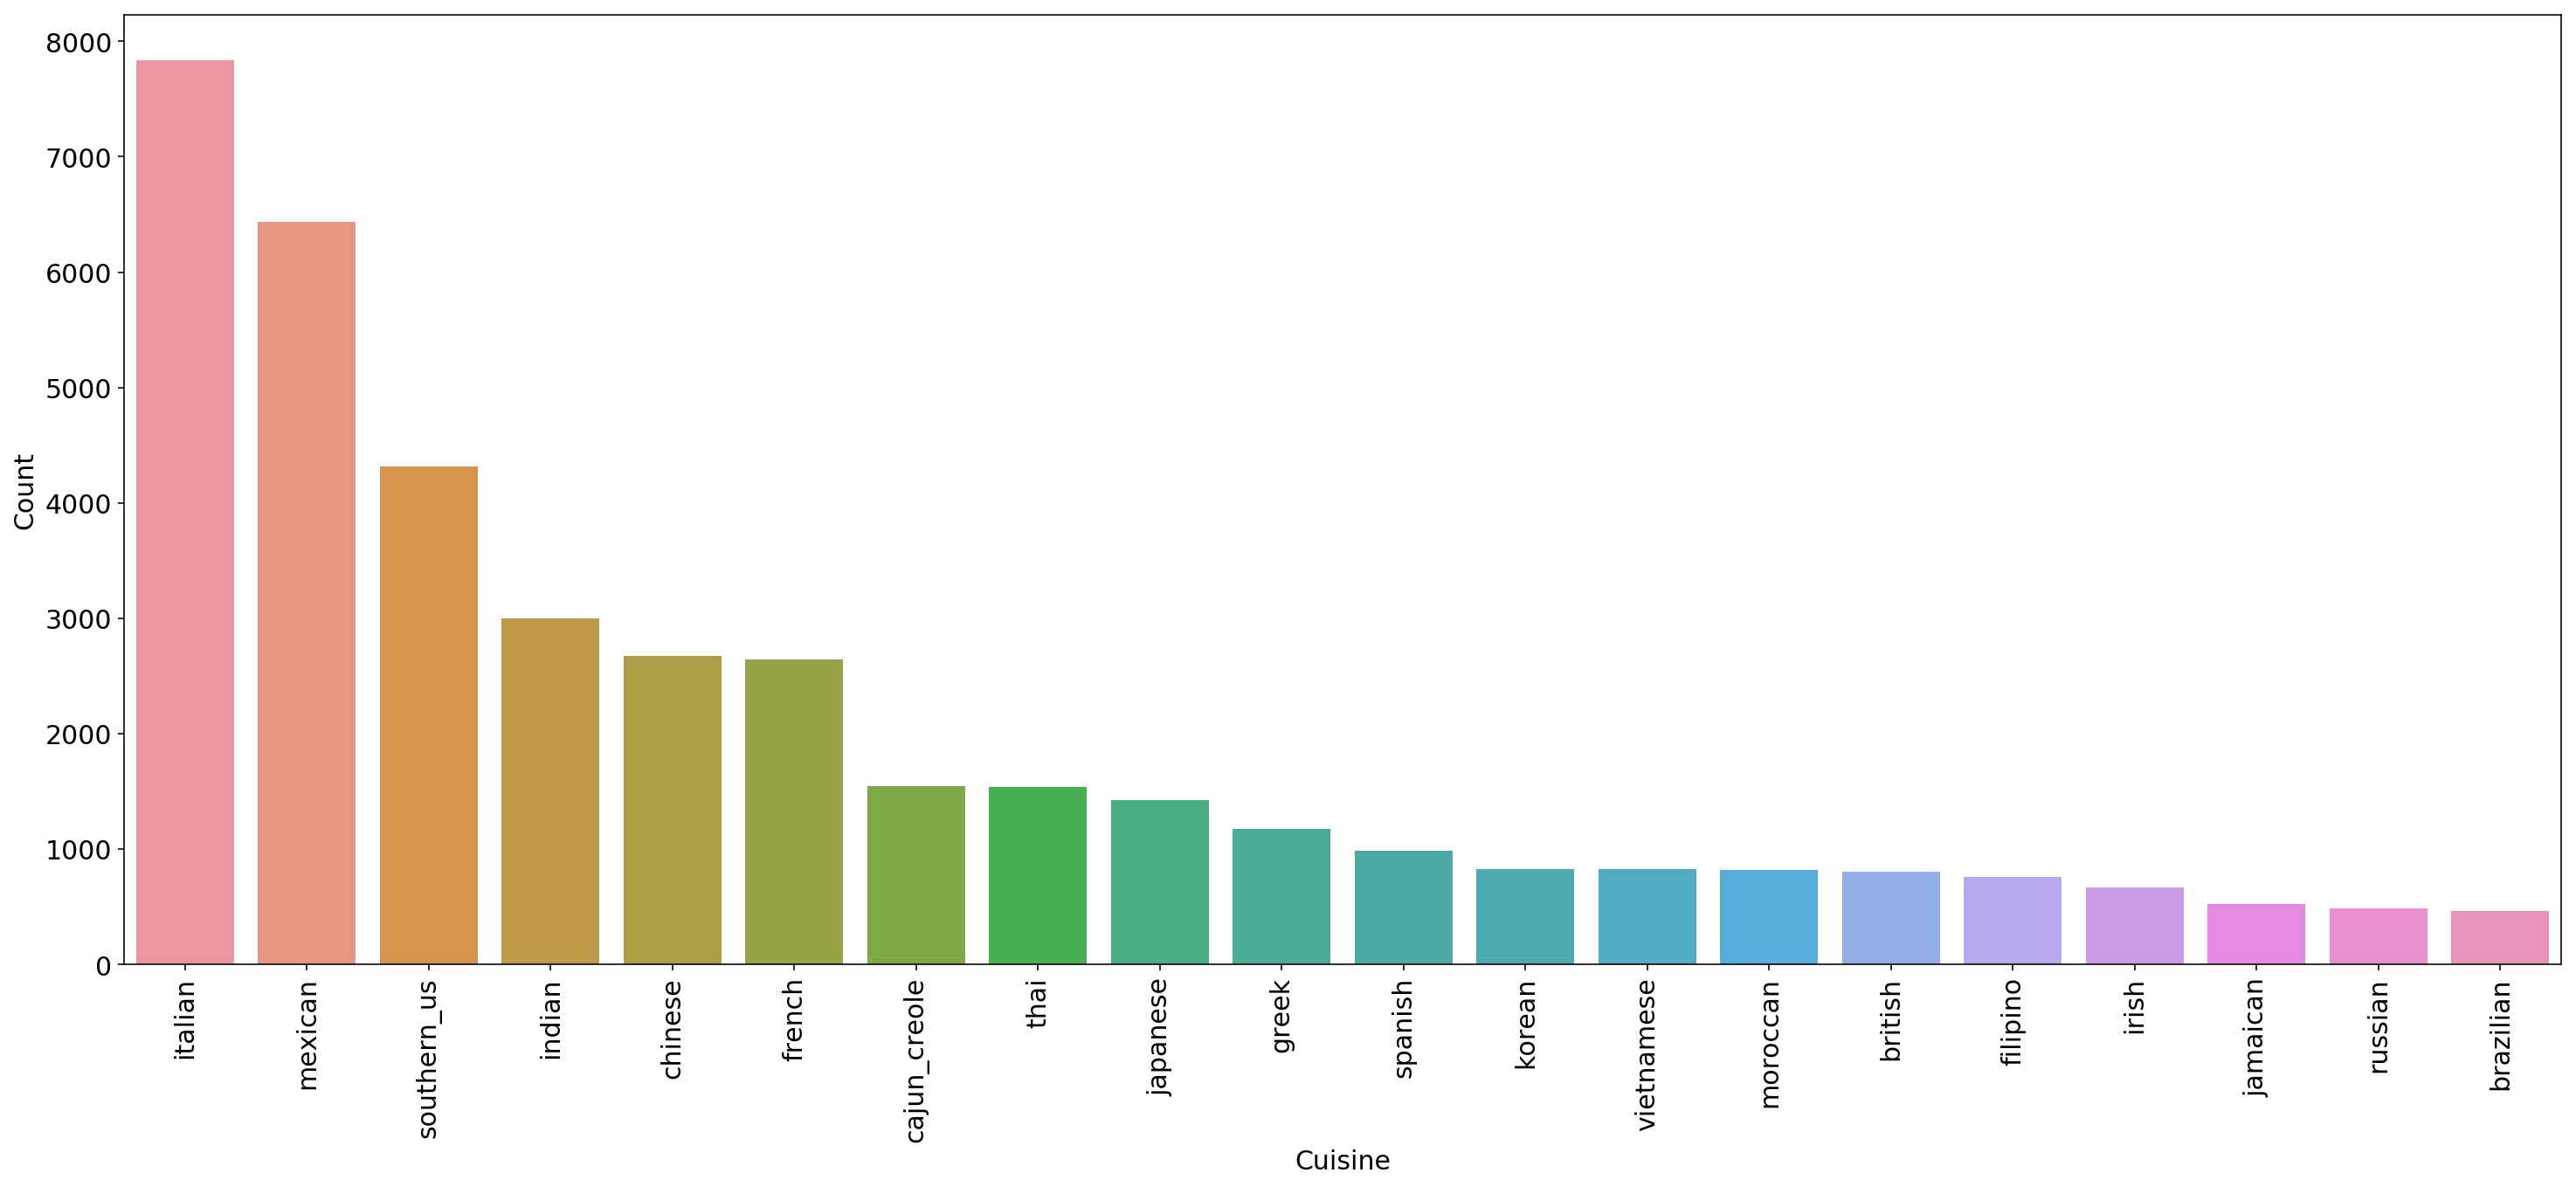

In [5]:
plt.figure(figsize=(25,10))
f = sns.countplot(train.cuisine,order=list(train.cuisine.value_counts().index))
f.set_xticklabels(f.get_xticklabels(), rotation=90)
f.tick_params(labelsize=15)
f.set_xlabel('Cuisine', fontsize=15)
f.set_ylabel('Count', fontsize=15)


In [6]:
# plt.figure(figsize=(15,10))
# train.cuisine.value_counts().plot.pie(autopct='%1.2f%%')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [8]:
train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [9]:
','.join(train.iloc[0].ingredients)

'romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles'

In [10]:
def preprocess(ingr):
    ingr_text = ' '.join(ingr)
    ingr_text = ingr_text.lower()
    ingr_text = ingr_text.replace('-', ' ')
    words = []
    for word in ingr_text.split():
        if re.findall('[0-9]', word): continue
        if len(word) <= 2: continue
        if len(word) > 0: words.append(word)
    return ' '.join(words)

In [11]:
train['ingredients_str'] = train.ingredients.apply(preprocess)
train.head()

,cuisine,id,ingredients,ingredients_str
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


In [12]:
X = train.ingredients_str
y = train.cuisine

In [13]:
run = RandomUnderSampler(random_state=0)
Xun, yun = run.fit_resample(X.values.reshape((-1,1)),y)
pd.Series(yun).value_counts()

korean          467
spanish         467
jamaican        467
vietnamese      467
mexican         467
japanese        467
irish           467
indian          467
chinese         467
southern_us     467
thai            467
italian         467
british         467
russian         467
french          467
cajun_creole    467
greek           467
filipino        467
brazilian       467
moroccan        467
dtype: int64

In [14]:
rov = RandomOverSampler(random_state=0)
Xov, yov = rov.fit_resample(X.values.reshape((-1,1)),y)

In [35]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X.ravel(),y, stratify=y, test_size=0.2, random_state=0)
kfold = StratifiedKFold(n_splits=5, random_state=0)

In [36]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', MultinomialNB())])
param_grid = {'tfidf__ngram_range':[(1,2)], 'clf__alpha':[0.01]}
grid = GridSearchCV(pipeline, param_grid, cv=kfold, return_train_score=True)
grid.fit(Xtrain, ytrain)
grid.best_params_

{'clf__alpha': 0.01, 'tfidf__ngram_range': (1, 2)}

In [37]:
bayes = grid.best_estimator_
print('Train accuracy: {}'.format(bayes.score(Xtrain, ytrain)))
print('Test accuracy: {}'.format(bayes.score(Xtest, ytest)))

Train accuracy: 0.9423929098966026
Test accuracy: 0.7449402891263356


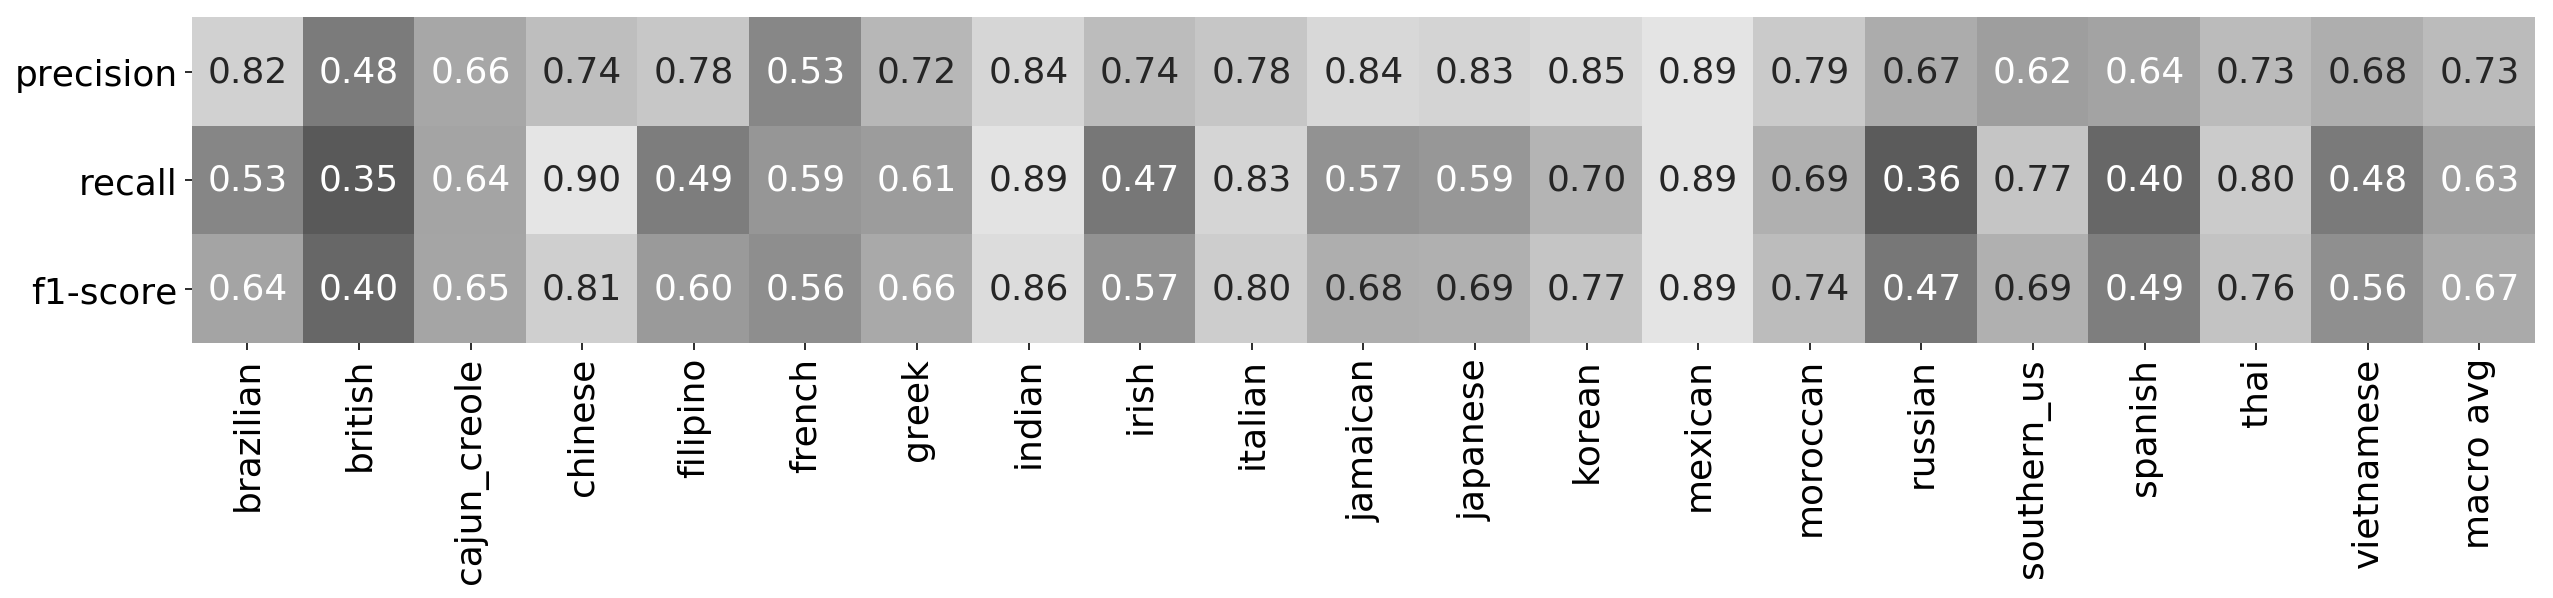

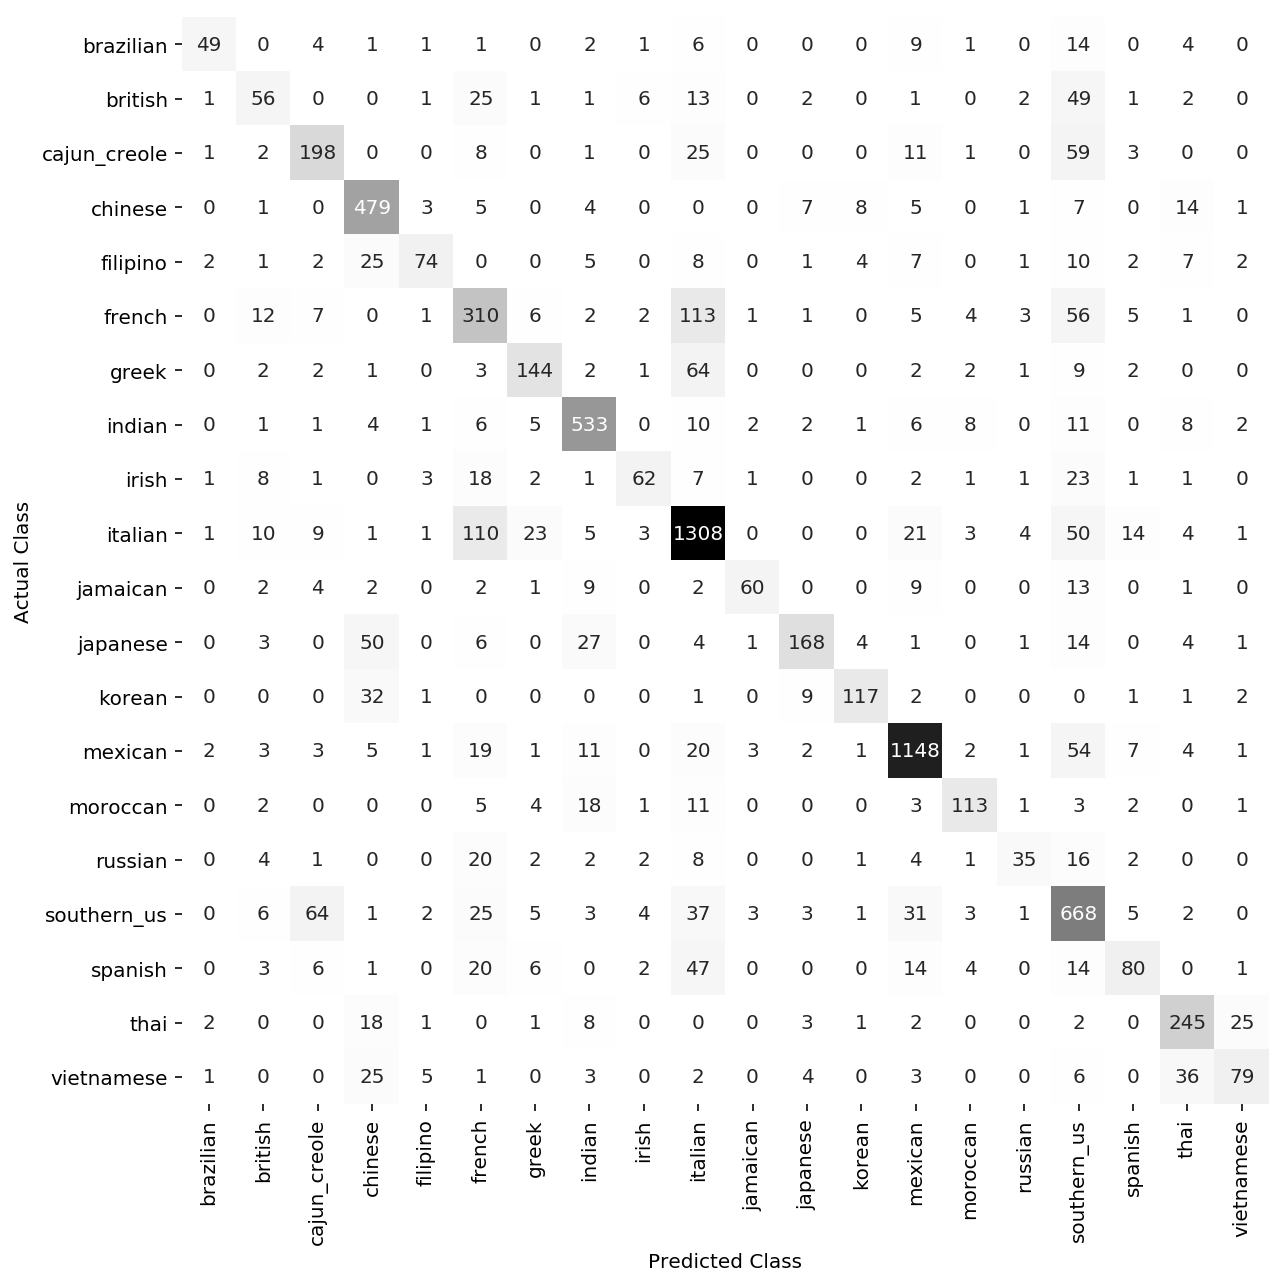

In [38]:
model = bayes
y_pred = model.predict(Xtest)
prf=pd.DataFrame(classification_report(ytest, y_pred, output_dict=True)).round(3)
prf = prf.drop('support', axis=0).drop(['accuracy', 'weighted avg'], axis=1).iloc[[1,2,0]]
plt.figure(figsize=(21,3))
sns.heatmap(prf, annot=True, fmt='.2f', vmin=0, vmax=1,cbar=False, cmap='gray',annot_kws={"fontsize":18})
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='1', square=True, cbar=False, xticklabels=model.classes_, yticklabels=model.classes_, cmap='binary')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [39]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier())])
param_grid = {'tfidf__ngram_range':[(1,2)],'clf__max_depth':range(49,50)}

grid = GridSearchCV(pipeline, param_grid, cv=kfold, return_train_score=True)
grid.fit(Xtrain, ytrain)
grid.best_params_

{'clf__max_depth': 49, 'tfidf__ngram_range': (1, 2)}

In [ ]:
tree = grid.best_estimator_
print('Train accuracy: {}'.format(tree.score(Xtrain, ytrain)))
print('Test accuracy: {}'.format(tree.score(Xtest, ytest)))

Train accuracy: 0.8902542506049844
Test accuracy: 0.6086737900691389


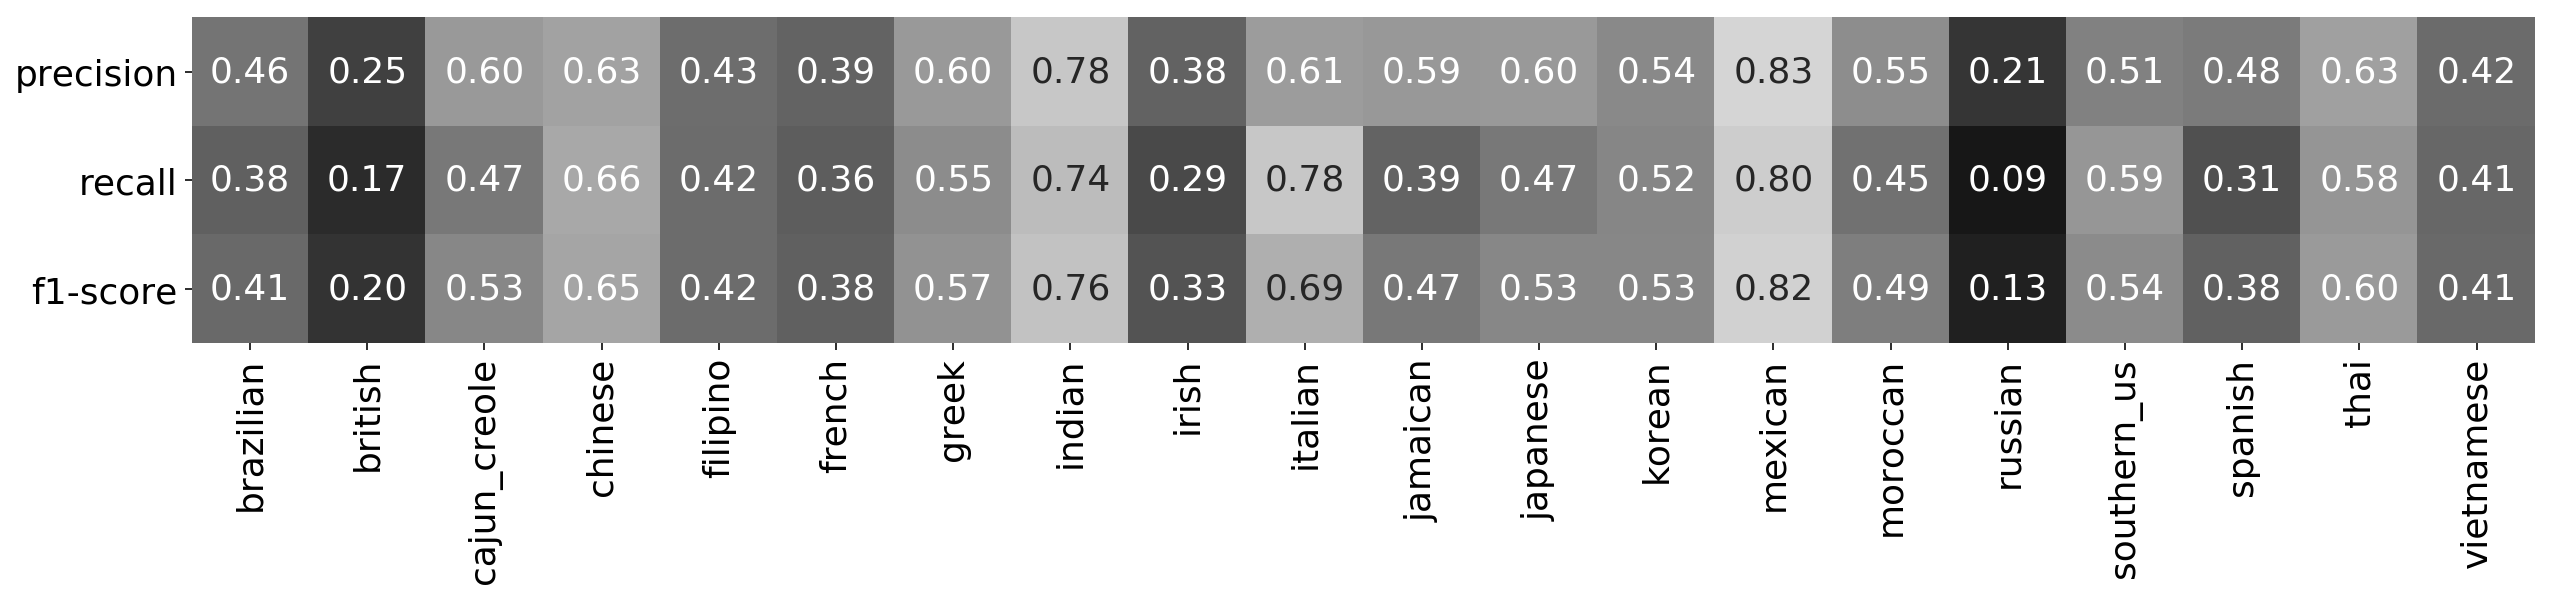

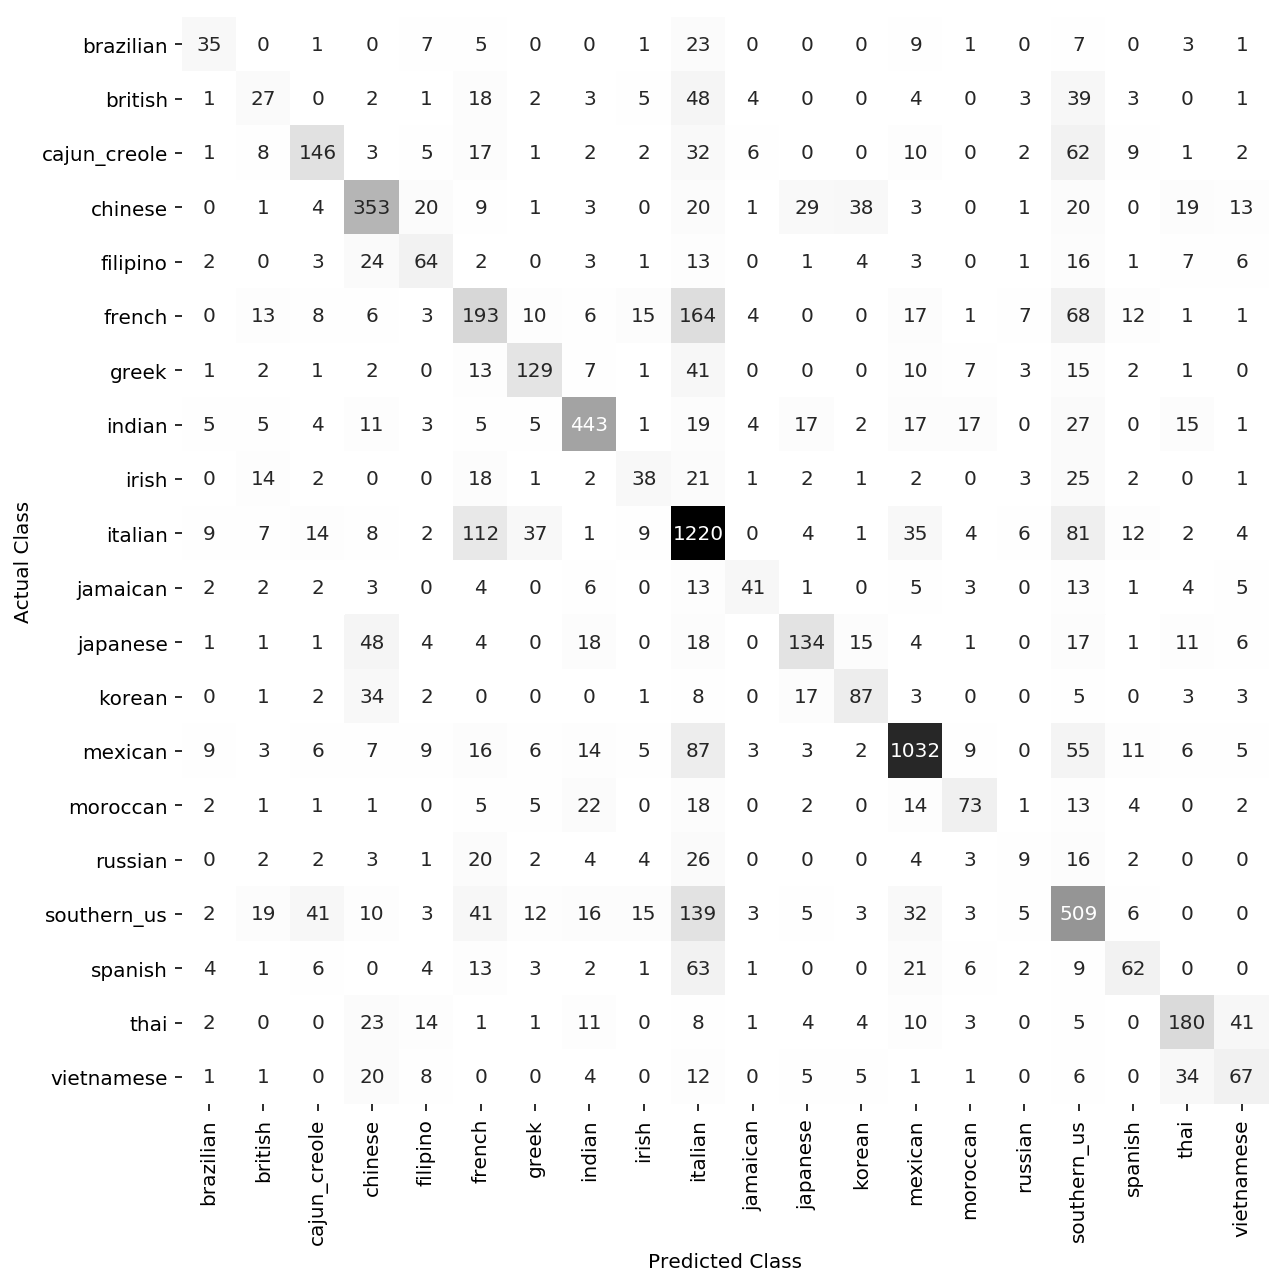

In [ ]:
model=tree
y_pred = model.predict(Xtest)
prf=pd.DataFrame(classification_report(ytest, y_pred, output_dict=True)).round(3)
prf = prf.drop('support', axis=0).drop(['accuracy','macro avg', 'weighted avg'], axis=1).iloc[[1,2,0]]
plt.figure(figsize=(21,3))
sns.heatmap(prf, annot=True, fmt='.2f', vmin=0, vmax=1,cbar=False, cmap='gray',annot_kws={"fontsize":18})
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='1', square=True, cbar=False, xticklabels=model.classes_, yticklabels=model.classes_, cmap='binary')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [ ]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SVC())])
param_grid = {'tfidf__ngram_range':[(1,2)],'clf__kernel':['linear'], 'clf__C':[0.001] }

grid = GridSearchCV(pipeline, param_grid, cv=kfold, return_train_score=True)
grid.fit(Xtrain, ytrain)
grid.best_params_

In [ ]:
svm = grid.best_estimator_
print('Train accuracy: {}'.format(tree.score(Xtrain, ytrain)))
print('Test accuracy: {}'.format(tree.score(Xtest, ytest)))

In [ ]:
model=svm
y_pred = model.predict(Xtest)
prf=pd.DataFrame(classification_report(ytest, y_pred, output_dict=True)).round(3)
prf = prf.drop('support', axis=0).drop(['accuracy','macro avg', 'weighted avg'], axis=1).iloc[[1,2,0]]
plt.figure(figsize=(21,3))
sns.heatmap(prf, annot=True, fmt='.2f', vmin=0, vmax=1,cbar=False, cmap='gray',annot_kws={"fontsize":18})
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytest, y_pred), annot=True, fmt='1', square=True, cbar=False, xticklabels=model.classes_, yticklabels=model.classes_, cmap='binary')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()